# Machine Learning Model for the Planetary Albedo

## Part one

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

### Load dataset

In [2]:
Albedo_Map = pd.read_csv('https://raw.githubusercontent.com/ML4SCI/ML4SCI_GSoC/main/Messenger/Moon/Albedo_Map.csv', header=None)
LPFe_Map = pd.read_csv('https://raw.githubusercontent.com/ML4SCI/ML4SCI_GSoC/main/Messenger/Moon/LPFe_Map.csv', header=None)
LPK_Map = pd.read_csv('https://raw.githubusercontent.com/ML4SCI/ML4SCI_GSoC/main/Messenger/Moon/LPK_Map.csv', header=None)
LPTh_Map = pd.read_csv('https://raw.githubusercontent.com/ML4SCI/ML4SCI_GSoC/main/Messenger/Moon/LPTh_Map.csv', header=None)
LPTi_Map = pd.read_csv('https://raw.githubusercontent.com/ML4SCI/ML4SCI_GSoC/main/Messenger/Moon/LPTi_Map.csv', header=None)

In [3]:
# Plot data values with seaborn heatmap

def heatmaps(datasets, nrow, ncol):
    for (key, value), i in zip(datasets.items(), range(len(datasets))):
        plt.subplot(nrow, ncol, i+1)
        ax = sns.heatmap(value, annot=False, cbar=False, xticklabels=False, yticklabels=False, cmap=sns.color_palette("Spectral", as_cmap=True))
        ax.set_title(key)

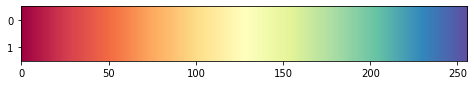

In [4]:
# Scale to be used

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

plt.figure(figsize=(8, 1))
ax = plt.imshow(gradient, aspect='auto', cmap=sns.color_palette("Spectral", as_cmap=True))

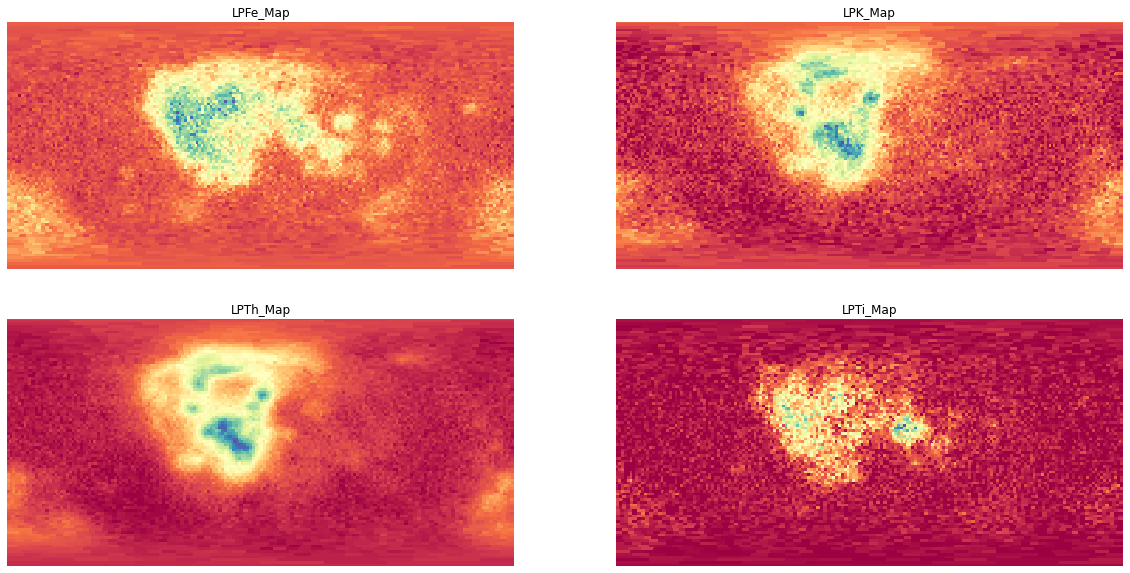

In [5]:
plt.rcParams.update({'figure.figsize': (20, 10)})

heatmaps({'LPFe_Map':LPFe_Map, 'LPK_Map':LPK_Map, 'LPTh_Map':LPTh_Map, 'LPTi_Map':LPTi_Map}, 2, 2)

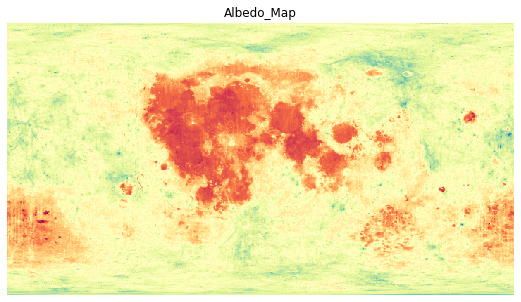

In [6]:
plt.rcParams.update({'figure.figsize': (20, 5)})

heatmaps({'Albedo_Map':Albedo_Map}, 1, 2)

### Regression

In [7]:
# Flatten dataset into unique DataFrame
X = pd.DataFrame({'LPFe_Map':LPFe_Map.values.flatten(order='F'), # Fortran (column-major) order
                  'LPK_Map':LPK_Map.values.flatten(order='F'), 
                  'LPTh_Map':LPTh_Map.values.flatten(order='F'), 
                  'LPTi_Map':LPTi_Map.values.flatten(order='F')})
y = pd.DataFrame({'Albedo_Map':Albedo_Map.values.flatten(order='F')})

Divide the data into two halves (left and right side of the Albedo), train on  one side (left) and predict the other.

In [8]:
half = len(y)//2

X_train = X.loc[:half,:].to_numpy()
y_train = y.loc[:half,:].to_numpy().ravel()
X_test = X.loc[half:,:].to_numpy()
y_test = y.loc[half:,:].to_numpy().ravel()

We perform the regression with simpler models, evaluate and see if they perform appropriately to the problem.

Starting with the Classic Linear Regression model: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [9]:
%%time
from sklearn.linear_model import LinearRegression

lm = LinearRegression().fit(X_train, y_train)

CPU times: user 156 ms, sys: 93.8 ms, total: 250 ms
Wall time: 250 ms


Let's evaluate the coefficient of determination $R^2$ of the prediction

In [10]:
lm.score(X_train, y_train)

0.7269161932277656

It's not that bad, but we can improve. Let's try the Ridge Regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV

In [11]:
%%time
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]).fit(X_train, y_train)
ridge.alpha_

CPU times: user 203 ms, sys: 312 ms, total: 516 ms
Wall time: 88.7 ms


100.0

In [12]:
ridge.score(X_train, y_train)

0.7269161787458924

There was almost no improvement. Let's see the Lasso: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV

In [13]:
%%time
from sklearn.linear_model import LassoCV

lasso = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]).fit(X_train, y_train)
lasso.alpha_

CPU times: user 141 ms, sys: 469 ms, total: 609 ms
Wall time: 132 ms


0.001

In [14]:
lasso.score(X_train, y_train)

0.7259975860476158

Elastic Net: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html

In [15]:
%%time
from sklearn.linear_model import ElasticNetCV

elastic = ElasticNetCV(cv=5).fit(X_train, y_train)

CPU times: user 2.7 s, sys: 3.94 s, total: 6.64 s
Wall time: 995 ms


In [16]:
elastic.score(X_train, y_train)

0.6869724626952942

Continues that way. Let's try something different, a random forest regressor: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

In [17]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


parameters = {
    'bootstrap':[True, False],
    'n_estimators':[10, 30, 100]
}
clf = GridSearchCV(RandomForestRegressor(criterion='mse'), parameters, cv=5, scoring='r2')
clf.fit(X_train, y_train)

CPU times: user 3min 45s, sys: 1.42 s, total: 3min 46s
Wall time: 3min 47s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'n_estimators': [10, 30, 100]},
             scoring='r2')

In [18]:
rdf = clf.best_estimator_ # n_estimators=30 and bootstrap=True
print(rdf)
rdf.score(X_train, y_train)

RandomForestRegressor()


0.9446963398164776

Much better! Through the metric $R^2$ we can select the model RandomForestRegressor to make predictions

In [19]:
predicted = rdf.predict(X_test)

Y = pd.DataFrame({'actual':y_test, 'predicted':predicted, 'residuals':(y_test - predicted)**2})
Y.head()

actual  predicted  residuals
0  0.318497   0.330753   0.000150
1  0.319254   0.330753   0.000132
2  0.313630   0.297560   0.000258
3  0.336727   0.297560   0.001534
4  0.329803   0.297560   0.001040

In [20]:
Y['residuals'].describe()

count    1.296000e+05
mean     1.172231e-03
std      1.983161e-03
min      5.790203e-13
25%      9.521074e-05
50%      4.411619e-04
75%      1.385971e-03
max      4.652056e-02
Name: residuals, dtype: float64

Visually checking

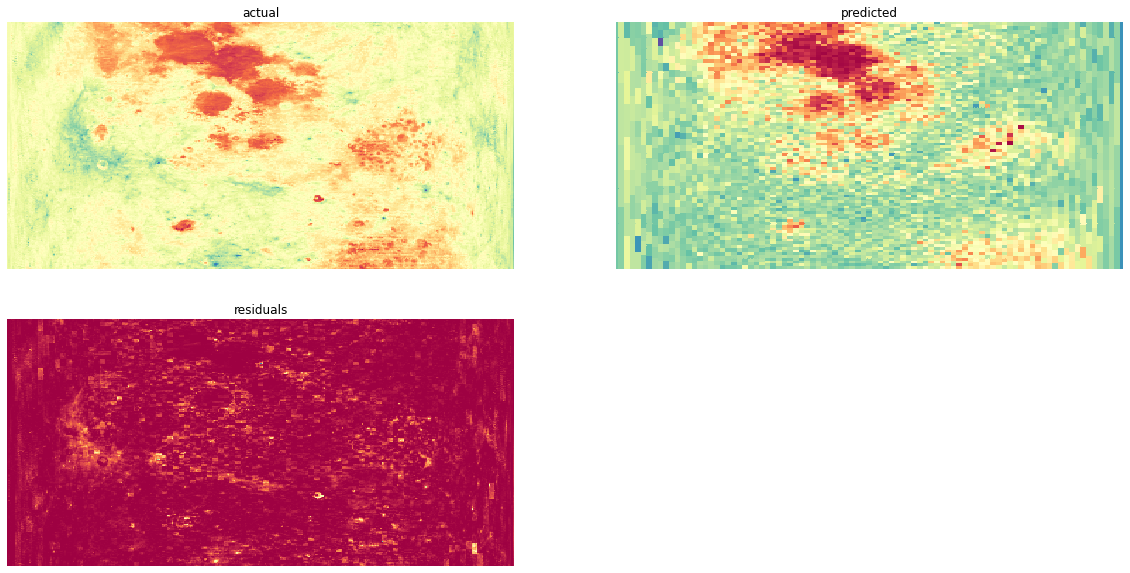

In [21]:
plt.rcParams.update({'figure.figsize': (20, 10)})

heatmaps({'actual':Y['actual'].values.reshape(-1, Albedo_Map.shape[0]),
          'predicted':Y['predicted'].values.reshape(-1, Albedo_Map.shape[0]),
          'residuals':Y['residuals'].values.reshape(-1, Albedo_Map.shape[0])}, 2, 2)

Looks nice! Remembering: more purple, closer to the lower value

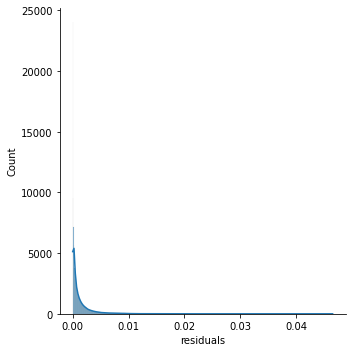

In [22]:
ax = sns.displot(Y, x="residuals", kde=True)

As you can see, the residues were very low.

## Part two

### Load dataset

In [23]:
Al2Si = pd.read_csv('https://raw.githubusercontent.com/ML4SCI/ML4SCI_GSoC/main/Messenger/Mercury/alsimap_smooth_032015.png.csv', header=None)
Ca2Si = pd.read_csv('https://raw.githubusercontent.com/ML4SCI/ML4SCI_GSoC/main/Messenger/Mercury/casimap_smooth_032015.png.csv', header=None)
Fe2Si = pd.read_csv('https://raw.githubusercontent.com/ML4SCI/ML4SCI_GSoC/main/Messenger/Mercury/fesimap_smooth_032015.png.csv', header=None)
Mg2Si = pd.read_csv('https://raw.githubusercontent.com/ML4SCI/ML4SCI_GSoC/main/Messenger/Mercury/mgsimap_smooth_032015.png.csv', header=None)
S2Si = pd.read_csv('https://raw.githubusercontent.com/ML4SCI/ML4SCI_GSoC/main/Messenger/Mercury/ssimap_smooth_032015.png.csv', header=None)
Mercury_btn = pd.read_csv('https://raw.githubusercontent.com/ML4SCI/ML4SCI_GSoC/main/Messenger/Mercury/mercury-albedo-resized-bottom-half.png.csv', header=None)
Mercury_top = pd.read_csv('https://raw.githubusercontent.com/ML4SCI/ML4SCI_GSoC/main/Messenger/Mercury/mercury-albedo-top-half.png.csv', header=None)

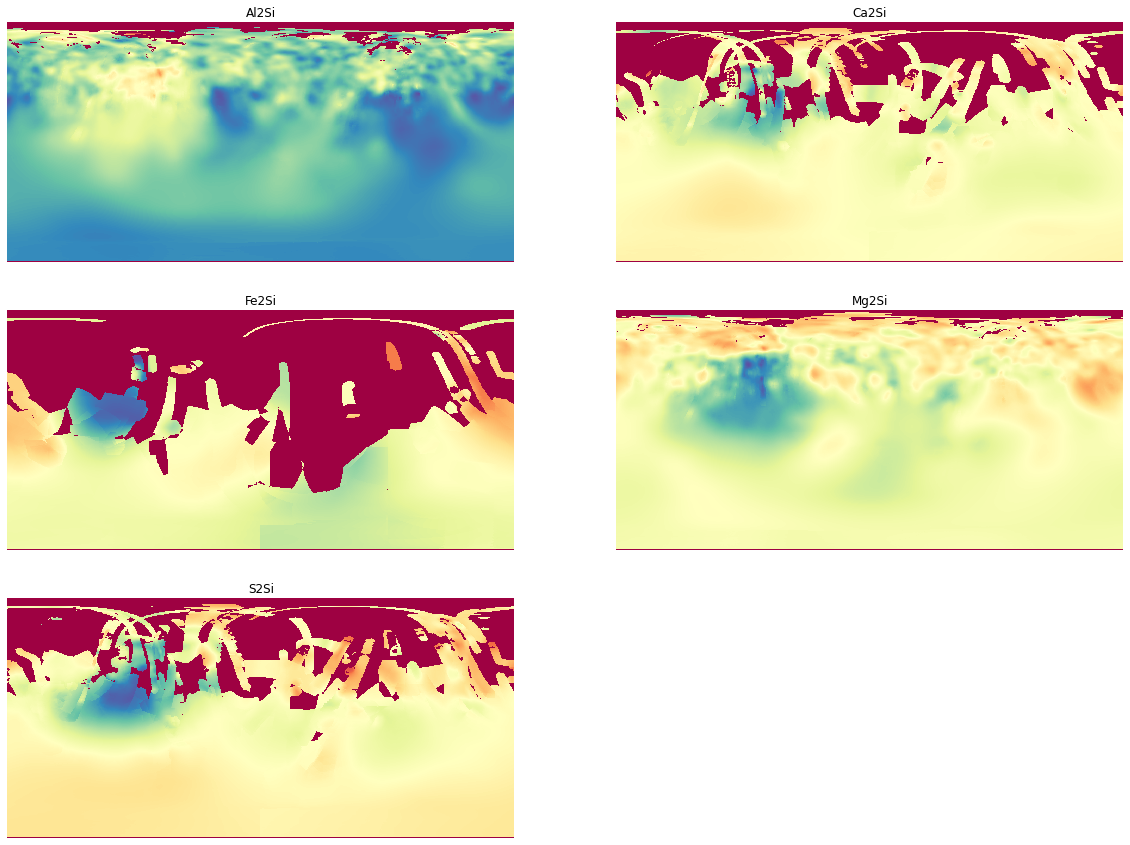

In [24]:
plt.rcParams.update({'figure.figsize': (20, 15)})

heatmaps({'Al2Si':Al2Si, 'Ca2Si':Ca2Si, 'Fe2Si':Fe2Si, 'Mg2Si':Mg2Si, 'S2Si':S2Si}, 3, 2)

There are many gaps! (null values).

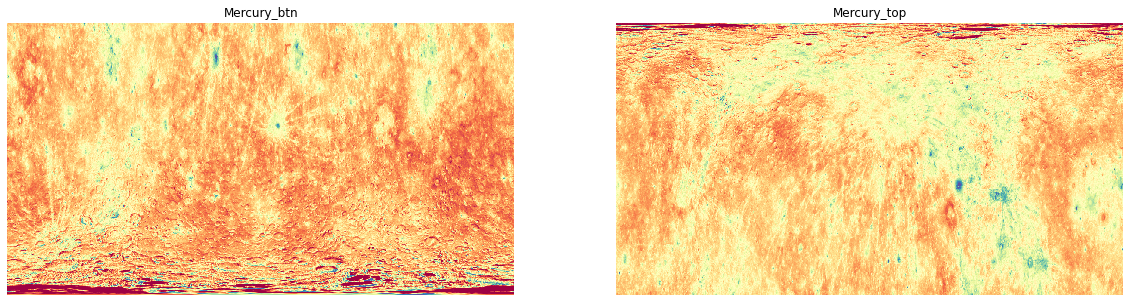

In [25]:
plt.rcParams.update({'figure.figsize': (20, 5)})

heatmaps({'Mercury_btn':Mercury_btn, 'Mercury_top':Mercury_top}, 1, 2)

In [26]:
# Fortran (column-major) order
chemical = pd.DataFrame({'Al2Si':Al2Si.values.flatten(order='F'),
                         'Ca2Si':Ca2Si.values.flatten(order='F'), 
                         'Fe2Si':Fe2Si.values.flatten(order='F'), 
                         'Mg2Si':Mg2Si.values.flatten(order='F'), 
                         'S2Si':S2Si.values.flatten(order='F')})
mercury = pd.DataFrame({'Mercury_top':Mercury_top.values.flatten(order='F'),
                        'Mercury_btn':Mercury_btn.values.flatten(order='F')})

### Filling in the gaps

As we do not have many input variables, we will build some from the statistical measures in our windowed database. So, to help find relationships between albedo and chemical composition in the top of the planet, we use this ideia in time domain.

In [27]:
# As window, we use the number of rows from original database
window = Mercury_top.shape[0]

def stats_features(X, window):
    df = pd.DataFrame({'x': X,
                      'min': X.rolling(window=window).min(),
                      'max': X.rolling(window=window).max(),
                      'mean': X.rolling(window=window).mean(),
                      'var': X.rolling(window=window).var(),
                      'skew': X.rolling(window=window).skew(),
                      'kurt': X.rolling(window=window).kurt()})
    df['min'].fillna(df['x'], inplace=True)
    df['max'].fillna(df['x'], inplace=True)
    df['mean'].fillna(df['x'], inplace=True)
    df['var'].fillna(df['x'], inplace=True)
    df['skew'].fillna(df['x'], inplace=True)
    df['kurt'].fillna(df['x'], inplace=True)

    return df

Mercury_top_stats = stats_features(mercury['Mercury_top'], window)
Mercury_btn_stats = stats_features(mercury['Mercury_btn'], window)

In [28]:
index_train = chemical.apply(lambda x: np.where(x != 0)[0])
index_test = chemical.apply(lambda x: np.where(x == 0)[0])

X_train = {c: Mercury_top_stats.loc[index_train[c],:].to_numpy() for c in chemical.columns}
y_train = {c: chemical.loc[index_train[c], c].to_numpy().ravel() for c in chemical.columns}

X_test = {c: Mercury_top_stats.loc[index_test[c],:].to_numpy() for c in chemical.columns}

In [29]:
%%time
# Linear Regression

lm = [LinearRegression().fit(X_train[c], y_train[c]) for c in chemical.columns]
[l.score(X_train[c], y_train[c]) for c, l in zip(chemical.columns, lm)]

CPU times: user 1.05 s, sys: 1.19 s, total: 2.23 s
Wall time: 1.01 s


[0.050246853443317474,
 0.014791481407608997,
 0.1259800829437725,
 0.04968920721839698,
 0.024240074866673123]

In [30]:
%%time
# Ridge Regression

ridge = [RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]).fit(X_train[c], y_train[c]) for c in chemical.columns]
[r.score(X_train[c], y_train[c]) for c, r in zip(chemical.columns, ridge)]

CPU times: user 15.9 s, sys: 32.4 s, total: 48.3 s
Wall time: 8.64 s


[0.05024685221625791,
 0.014791468434926847,
 0.12598008005891492,
 0.049689206500641236,
 0.02424007385293181]

In [31]:
%%time
# LASSO

lasso = [LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]).fit(X_train[c], y_train[c]) for c in chemical.columns]
[l.score(X_train[c], y_train[c]) for c, l in zip(chemical.columns, lasso)]

CPU times: user 15.8 s, sys: 26 s, total: 41.8 s
Wall time: 6.94 s


[0.0, 0.0, 0.08852888880699572, 0.0, 0.0]

In [32]:
%%time
# Elastic Net

elastic = [ElasticNetCV(cv=5).fit(X_train[c], y_train[c]) for c in chemical.columns]
[e.score(X_train[c], y_train[c]) for c, e in zip(chemical.columns, elastic)]

CPU times: user 37.5 s, sys: 46.4 s, total: 1min 23s
Wall time: 28.6 s


[0.0, 0.0, 0.113744829210222, 0.0, 0.002393177667382007]

As the following models take longer, we will try to "kick" some hiperparameters

In [33]:
%%time
# Random Forest Regressor

rdf = [RandomForestRegressor(max_features='auto', n_estimators=100, criterion='mse').fit(X_train[c], y_train[c]) for c in chemical.columns]
[r.score(X_train[c], y_train[c]) for c, r in zip(chemical.columns, rdf)]

CPU times: user 52min 52s, sys: 1min 4s, total: 53min 56s
Wall time: 55min 39s


[0.9920028274119216,
 0.9911591986295598,
 0.996263512562201,
 0.9923324071673009,
 0.993931138474464]

It's good, but let's try a simpler neural network: https://scikit-learn.org/stable/modules/neural_networks_supervised.html#regression

In [34]:
%%time
from sklearn.neural_network import MLPRegressor


regr = [MLPRegressor(activation='tanh', hidden_layer_sizes=200, early_stopping=True).fit(X_train[c], y_train[c]) for c in chemical.columns]
[r.score(X_train[c], y_train[c]) for c, r in zip(chemical.columns, regr)]

CPU times: user 5h 10min 39s, sys: 6h 21min 7s, total: 11h 31min 47s
Wall time: 1h 46min 49s


[0.18334288293358125,
 0.05706834021895313,
 0.248886271906684,
 0.12593318673048848,
 0.1217143363090929]

We can also try something newer: XGBoost is an algorithm that has recently been dominating applied machine learning and Kaggle competitions for structured or tabular data: https://xgboost.readthedocs.io/en/latest/python/python_api.html

In [35]:
%%time
from xgboost.sklearn import XGBRegressor


xgb = [XGBRegressor(verbosity=0, learning_rate=0.01, gamma=2, subsample=0.2).fit(X_train[c], y_train[c]) for c in chemical.columns]
[x.score(X_train[c], y_train[c]) for c, x in zip(chemical.columns, xgb)]

CPU times: user 15min 11s, sys: 3.67 s, total: 15min 15s
Wall time: 2min 15s


[-0.8290845342108091,
 0.06578834151766788,
 0.26718788362880885,
 0.1279068125102647,
 0.16547330449625453]

As we can see, Random Forest Regressor had the best performance. We will choose it to fill in the gaps:

Seeing how the filling took place

In [36]:
predicteds = [m.predict(X_test[c]) for c, m in zip(chemical.columns, rdf)]

for c, i in zip(chemical.columns, range(len(predicteds))):
  chemical[c].loc[index_test[c]] = predicteds[i]
chemical_plots = {c: chemical[c].values.reshape(-1, Mercury_top.shape[0]) for c in chemical.columns}

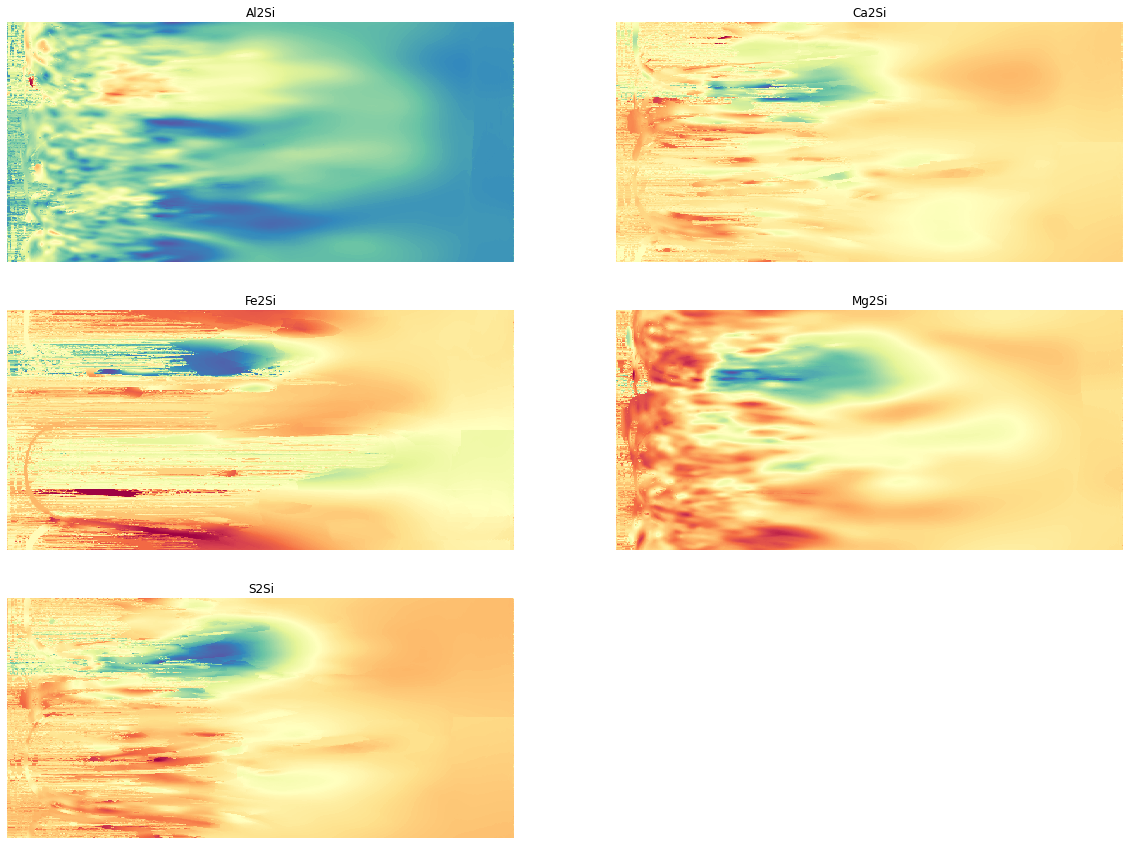

In [37]:
plt.rcParams.update({'figure.figsize': (20, 15)})

heatmaps(chemical_plots, 3, 2)

We would probably need a more complex model to fill these gaps. This article could give a good idea: https://www.hindawi.com/journals/cin/2016/6156513/

### Prediction

Now we take advantage of the three best adjusteds models to make predictions in Mercury botton

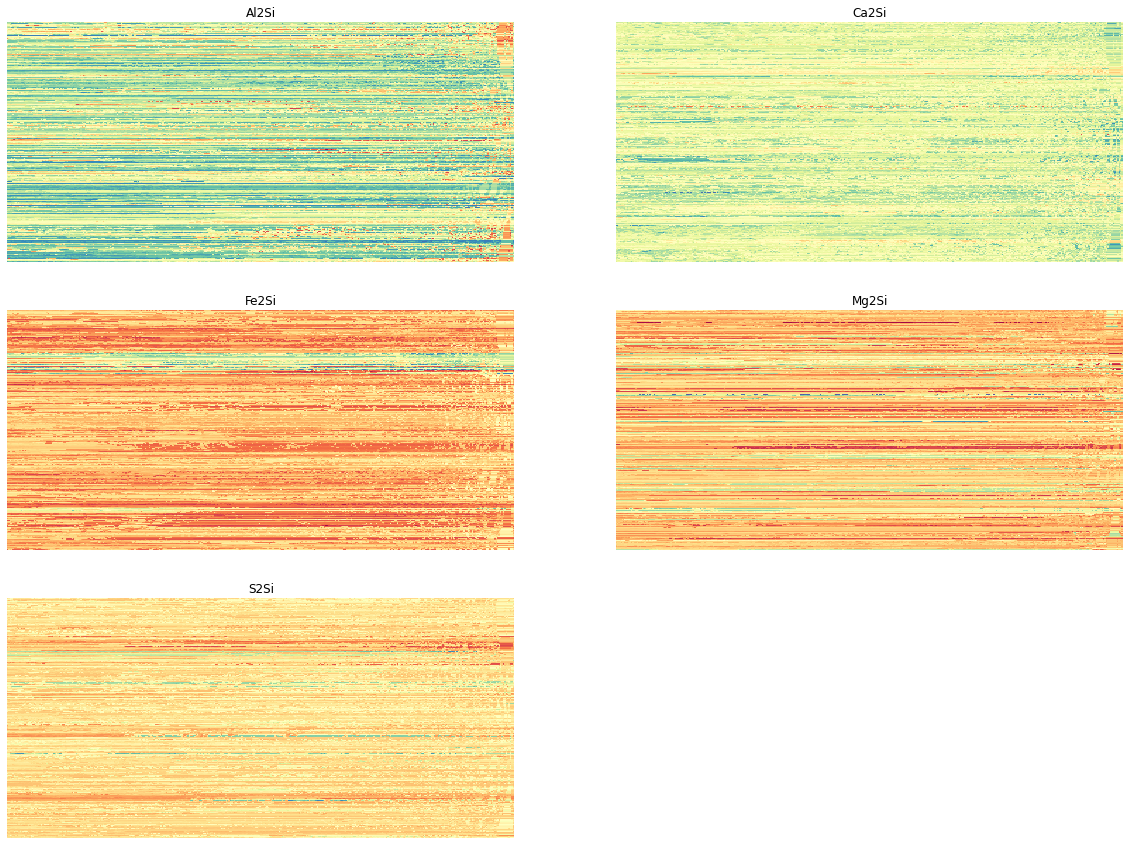

In [38]:
# Random Forest Regressor

plt.rcParams.update({'figure.figsize': (20, 15)})

predicteds_btn = {c: m.predict(Mercury_btn_stats).reshape(-1, Mercury_btn.shape[0]) for c, m in zip(chemical.columns, rdf)}
heatmaps(predicteds_btn, 3, 2)

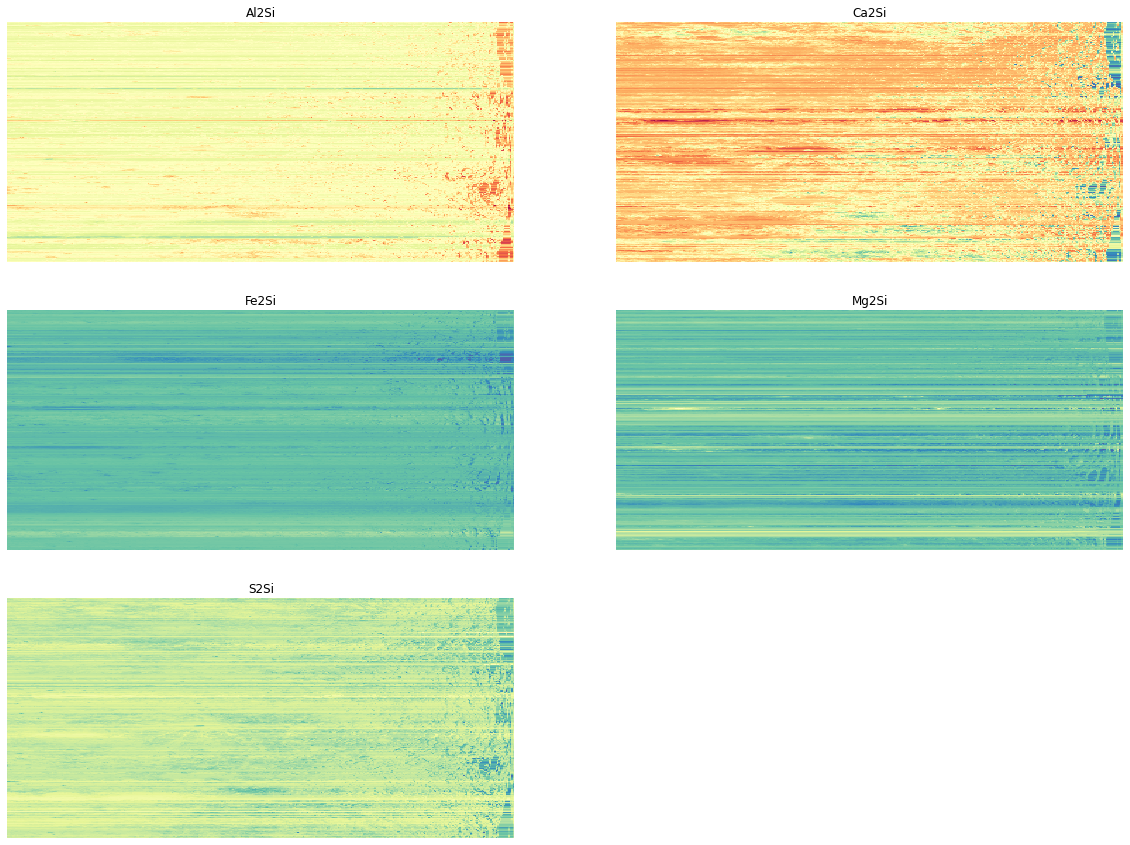

In [39]:
# MLPRegressor

plt.rcParams.update({'figure.figsize': (20, 15)})

predicteds_btn = {c: m.predict(Mercury_btn_stats).reshape(-1, Mercury_btn.shape[0]) for c, m in zip(chemical.columns, regr)}
heatmaps(predicteds_btn, 3, 2)

As can be seen in both models, mainly the Random Forest Regressor that presented the best fit by $R^2$, there was no good performance in the predict. This was very linear, as can be seen by the plots.

With that, I confirm the hypothesis that more complex (or appropriate) models should be applied to solve this problem. From filling the gaps (presenting in a linear way) to the prediction for the bottom.